# **A3: Predicting Car Price**
## Dechathon Niamsa-ard st126235
Github Link: https://github.com/dniamsaard4codework/A3-Predicting-Car-Price.git

Link to the website: 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pickle

print(mlflow.__version__)

/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:373:

2.8.1


## Objective of the assignment
- Convert car price prediction into classification problem using Logistic Regression.
- Implement evaluation metrics (Accuracy, Precision, Recall, F1, Macro, Weighted) from scratch.
- Extend Logistic Regression to include Ridge (L2) regularization.
- Log experiments on the MLflow server.
- Deploy the best model using MLflow Model Registry.
- Set up CI/CD pipeline with GitHub Actions and unit testing.

## Task 1: Classification

In this task, I need to use the preprocessed dataset from A1/A2, and convert `selling_price` into 4 classes (0-3). After that, I need to implement the classification report from scratch, compare with the sklearn's classification report, and answer what support means in the report.

### Load dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/Cars.csv')

# Display the first few rows of the dataframe
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
# Display statistical summary of the dataset
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


### Apply preprocessed from A1/A2 to the dataset

In [5]:
# Perform some data cleaning for better analysis and visualization
# Parse from numeric columns and handle empty strings
df.mileage = pd.to_numeric(df.mileage.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.engine = pd.to_numeric(df.engine.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.max_power = pd.to_numeric(df.max_power.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')

# Rename the columns for better understanding
df = df.rename(columns={'name':'brand'})

# Drop the torque column
df = df.drop(columns=['torque'], errors='ignore')

# Remove all rows with CNG and LPG fuel types
df = df[~df['fuel'].isin(['CNG', 'LPG'])]

# Take the first word of name and remove the rest for brand class
df.brand = df.brand.str.split(' ', expand=True)[0]

# map feature owner to be First owner to 1, ..., Test Drive Car to 5
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
df.owner = df.owner.map(owner_mapping).astype(int)

# Check the dataframe info
df.info()

# Remove the 'Test Drive Car' samples due not to involve in the training
df = df[df['owner'] != 5]

# Create a class that look like the above pipeline but using with custom model classes (Same as A2)

class ManualPreprocessor:
    def __init__(self, num_med_cols, num_mean_cols, cat_cols, drop_first=True):
        self.num_med_cols = list(num_med_cols)
        self.num_mean_cols = list(num_mean_cols)
        self.cat_cols = list(cat_cols)
        self.drop_first = drop_first
        # learned params
        self.medians_ = {}
        self.means_ = {}
        self.num_mean_for_scale_ = {}
        self.num_std_for_scale_ = {}
        self.cat_categories_ = {}
        self.feature_names_ = None
        self.is_fitted_ = False

    def fit(self, X: pd.DataFrame):
        X = X.copy()

        # 1) impute stats
        for c in self.num_med_cols:
            if c in X.columns:
                self.medians_[c] = X[c].median()
        for c in self.num_mean_cols:
            if c in X.columns:
                self.means_[c] = X[c].mean()

        # 2) impute to compute scaler on train
        for c in self.num_med_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.means_[c])

        # 3) scaler stats (column-wise)
        num_all = self.num_med_cols + self.num_mean_cols
        for c in num_all:
            if c in X.columns:
                self.num_mean_for_scale_[c] = X[c].mean()
                self.num_std_for_scale_[c] = X[c].std(ddof=0)
                # Ensure std is not zero
                if self.num_std_for_scale_[c] == 0:
                    self.num_std_for_scale_[c] = 1.0

        # 4) categorical categories (store train cats; unknowns will be ignored)
        for c in self.cat_cols:
            if c in X.columns:
                cats = pd.Index(pd.Series(X[c], dtype="object").dropna().unique())
                # Use a deterministic order:
                self.cat_categories_[c] = pd.Index(sorted(cats.astype(str)))

        # 5) build feature names (without bias)
        self._build_feature_names()
        self.is_fitted_ = True
        return self

    def _build_feature_names(self):
        """Helper method to build feature names"""
        num_names = self.num_med_cols + self.num_mean_cols
        cat_names = []
        for c in self.cat_cols:
            if c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # drop_first=True -> drop the first category
                cats_keep = cats[1:] if self.drop_first and len(cats) > 0 else cats
                cat_names += [f"{c}={val}" for val in cats_keep]
        self.feature_names_ = np.array(num_names + cat_names, dtype=object)

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before transform")
        
        X = X.copy()

        # 1) impute using train stats
        for c in self.num_med_cols:
            if c in X.columns and c in self.medians_:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns and c in self.means_:
                X[c] = X[c].fillna(self.means_[c])

        # 2) scale numeric
        num_all = self.num_med_cols + self.num_mean_cols
        X_num = []
        for c in num_all:
            if c in X.columns and c in self.num_mean_for_scale_:
                mu = self.num_mean_for_scale_[c]
                sd = self.num_std_for_scale_[c]
                X_num.append(((X[c].astype(float) - mu) / sd).to_numpy())
        X_num = np.column_stack(X_num) if X_num else np.empty((len(X), 0))

        # 3) one-hot categorical using TRAIN categories
        X_cat_parts = []
        for c in self.cat_cols:
            if c in X.columns and c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # force to training categories (unknown -> NaN -> all zeros after dummies)
                col = pd.Categorical(X[c].astype("object"), categories=cats)
                dummies = pd.get_dummies(col, prefix=c, prefix_sep='=', dummy_na=False)
                if self.drop_first and dummies.shape[1] > 0:
                    dummies = dummies.iloc[:, 1:]  # drop first category
                X_cat_parts.append(dummies.to_numpy(dtype=float))
        X_cat = np.column_stack(X_cat_parts) if X_cat_parts else np.empty((len(X), 0))

        # 4) concat numeric + categorical
        X_all = np.column_stack([X_num, X_cat]) if X_num.size > 0 or X_cat.size > 0 else np.empty((len(X), 0))

        # 5) add bias as first column
        bias = np.ones((X_all.shape[0], 1), dtype=float)
        X_with_bias = np.hstack([bias, X_all])
        return X_with_bias

    def fit_transform(self, X: pd.DataFrame) -> np.ndarray:
        return self.fit(X).transform(X)

    def get_feature_names(self, include_bias=False):
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before getting feature names")
        if include_bias:
            return np.array(["bias"] + list(self.feature_names_), dtype=object)
        return self.feature_names_.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   int64  
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  seats          7819 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 815.9+ KB


In [6]:
# Check the range of the selling_price column
print(f"Range of selling_price: {df['selling_price'].min()} to {df['selling_price'].max()}")
# Check the quartiles of the selling_price column
print(df['selling_price'].quantile([0.25, 0.5, 0.75]))

Range of selling_price: 29999 to 10000000
0.25    260000.0
0.50    450000.0
0.75    680000.0
Name: selling_price, dtype: float64


In [7]:
# Convert 'selling_price' to 'price_class' categorical variable with quartiles
# bins = [0, 200000, 500000, 1000000, df['selling_price'].max()]
# labels = [0,1,2,3]
# df['price_class'] = pd.cut(df['selling_price'], bins=bins, labels=labels, include_lowest=True)

# Separate with pd.cut with quantiles
quantiles = df['selling_price'].quantile([0,0.25,0.5,0.75,1]).values
df['price_class'] = pd.cut(
    df['selling_price'],
    bins=quantiles,
    labels=[0,1,2,3],
    include_lowest=True
)
df.price_class.value_counts().sort_index()

price_class
0    2050
1    2044
2    1943
3    1991
Name: count, dtype: int64

In [8]:
# Display the first few rows of the dataframe
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,price_class
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,1
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,1
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,0


In [9]:
# Convert 'price_class' to categorical type
df['price_class'] = df['price_class'].astype('category')
# Show the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   brand          8028 non-null   object  
 1   year           8028 non-null   int64   
 2   selling_price  8028 non-null   int64   
 3   km_driven      8028 non-null   int64   
 4   fuel           8028 non-null   object  
 5   seller_type    8028 non-null   object  
 6   transmission   8028 non-null   object  
 7   owner          8028 non-null   int64   
 8   mileage        7814 non-null   float64 
 9   engine         7814 non-null   float64 
 10  max_power      7820 non-null   float64 
 11  seats          7814 non-null   float64 
 12  price_class    8028 non-null   category
dtypes: category(1), float64(4), int64(4), object(4)
memory usage: 823.4+ KB


In [10]:
# Select relevant features for the model
features = ['year', 'km_driven', 'fuel', 'transmission', 'owner',
            'engine', 'max_power', 'brand', 'mileage']
target = 'price_class'
print(features)

['year', 'km_driven', 'fuel', 'transmission', 'owner', 'engine', 'max_power', 'brand', 'mileage']


In [11]:
from sklearn.model_selection import train_test_split

# Split training set and testing set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
# Create feature sets for numerical and categorical features
features_num = [ft for ft in features if train_set[ft].dtype in [np.float64, np.int64]]
features_cat = [ft for ft in features if train_set[ft].dtype == 'object']

print("Numerical features:", features_num)
print("Categorical features:", features_cat)

Numerical features: ['year', 'km_driven', 'owner', 'engine', 'max_power', 'mileage']
Categorical features: ['fuel', 'transmission', 'brand']


In [13]:
# Split the data into features and target label
X_train = train_set[features].copy()
X_test = test_set[features].copy()
y_train = train_set[target].copy()
y_test = test_set[target].copy()

In [14]:
print("The shape of training data is:", X_train.shape)
print("The shape of test data is:", X_test.shape)
print("The shape of training label is:", y_train.shape)
print("The shape of test label is:", y_test.shape)

The shape of training data is: (6422, 9)
The shape of test data is: (1606, 9)
The shape of training label is: (6422,)
The shape of test label is: (1606,)


In [15]:
# Define numerical columns for median and mean imputation
num_med_cols = [c for c in features_num if c != 'mileage']
num_mean_cols = ['mileage']

# Define categorical columns
cat_cols = features_cat

prep = ManualPreprocessor(num_med_cols, num_mean_cols, cat_cols, drop_first=True) # Apply to the code for ManualPreprocessor
X_train_transformed = prep.fit_transform(X_train)
X_test_transformed = prep.transform(X_test)

# Display the shape of transformed data
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

# Display the type of transformed data
print("Type of X_train_transformed:", type(X_train_transformed))
print("Type of X_test_transformed:", type(X_test_transformed))
print("Type of y_train:", type(y_train))
print("Type of y_test:", type(y_test))

X_train_transformed shape: (6422, 38)
X_test_transformed shape: (1606, 38)
y train shape: (6422,)
y test shape: (1606,)
Type of X_train_transformed: <class 'numpy.ndarray'>
Type of X_test_transformed: <class 'numpy.ndarray'>
Type of y_train: <class 'pandas.core.series.Series'>
Type of y_test: <class 'pandas.core.series.Series'>


In [16]:
# Create one-hot encoded arrays for training
def to_one_hot(y, num_classes):
    """Convert numeric labels to one-hot encoding"""
    y = y.cat.codes  # Convert categorical to numeric codes
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

# Convert to one-hot for the model
y_train_one_hot = to_one_hot(y_train, 4)

print("Original y_train shape:", y_train.shape)
print("One-hot y_train shape:", y_train_one_hot.shape)

# Verify the conversion
print("\nFirst few y_train values:", y_train.head().values)
print("First few y_train:", y_train[:5])
print("First few y_train_one_hot:")
print(y_train_one_hot[:5])

Original y_train shape: (6422,)
One-hot y_train shape: (6422, 4)

First few y_train values: [0, 0, 0, 3, 0]
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train: 2982    0
2430    0
6294    0
6255    3
4253    0
Name: price_class, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train_one_hot:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### Modify LogisticRegression() class from `02 - Multinomial Logistic Regression.ipynb` 


In [17]:
class LogisticRegression(object):
    
    def __init__(self, regularization, k, n, method, alpha = 0.001, max_iter=5000):
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
        self.regularization = regularization
    
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k)
        self.losses = []
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "sto":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
        
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        loss = - np.sum(Y*np.log(h)) / m  
        loss += self.regularization(self.W, m) # add regularization term to the loss
        error = h - Y
        grad = self.softmax_grad(X, error) 
        grad += self.regularization.derivative(self.W, m) # add regularization term to the gradient
        return loss, grad

    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error

    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        return TP / (TP + FP) if (TP + FP) > 0 else 0.0

    def recall(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        return TP / (TP + FN) if (TP + FN) > 0 else 0.0

    def f1_score(self, y_true, y_pred, cls):
        prec = self.precision(y_true, y_pred, cls)
        rec = self.recall(y_true, y_pred, cls)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

    def macro_precision(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.precision(y_true, y_pred, cls) for cls in classes])

    def macro_recall(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.recall(y_true, y_pred, cls) for cls in classes])

    def macro_f1_score(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.f1_score(y_true, y_pred, cls) for cls in classes])

    def weighted_precision(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.precision(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    def weighted_recall(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.recall(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    def weighted_f1_score(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.f1_score(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    def classification_report(self, y_true, y_pred, digits=2):
        classes, counts = np.unique(y_true, return_counts=True)
        total_support = np.sum(counts)

        report = {}

        # Per-class metrics
        for cls, count in zip(classes, counts):
            cls_str = str(cls)
            p = self.precision(y_true, y_pred, cls)
            r = self.recall(y_true, y_pred, cls)
            f = self.f1_score(y_true, y_pred, cls)
            report[cls_str] = {
                "precision": round(p, digits),
                "recall": round(r, digits),
                "f1-score": round(f, digits),
                "support": int(count)
            }

        # Accuracy
        acc = self.accuracy(y_true, y_pred)
        report["accuracy"] = {
            "precision": "",
            "recall": "",
            "f1-score": round(acc, digits),
            "support": int(total_support)
        }

        # Macro avg
        macro_p = self.macro_precision(y_true, y_pred)
        macro_r = self.macro_recall(y_true, y_pred)
        macro_f = self.macro_f1_score(y_true, y_pred)
        report["macro avg"] = {
            "precision": round(macro_p, digits),
            "recall": round(macro_r, digits),
            "f1-score": round(macro_f, digits),
            "support": int(total_support)
        }

        # Weighted avg
        weighted_p = self.weighted_precision(y_true, y_pred)
        weighted_r = self.weighted_recall(y_true, y_pred)
        weighted_f = self.weighted_f1_score(y_true, y_pred)
        report["weighted avg"] = {
            "precision": round(weighted_p, digits),
            "recall": round(weighted_r, digits),
            "f1-score": round(weighted_f, digits),
            "support": int(total_support)
        }

        return pd.DataFrame(report).T

    

## Task 2: Ridge Logistic Regression

- Add Ridge Logistic Regression
    $$J(\theta) = -\sum_{i=1}^m y^{(i)}\log(h^{(i)}) + \lambda\sum_{j=1}^n \theta_j^{2}$$

In [18]:
# Define Ridge regularization and No regularization classes
class RidgePenalty:
    def __init__(self, l2):
        self.l2 = l2

    def __call__(self, theta, m):
        return (self.l2 / (2 * m)) * np.sum(np.square(theta))

    def derivative(self, theta, m):
        return (2 * self.l2 / m) * theta

class NoPenalty:
    def __call__(self, theta, m=None):
        return 0.0

    def derivative(self, theta, m=None):
        return np.zeros_like(theta)

class Ridge(LogisticRegression):
    def __init__(self, k, n, method, alpha, l2):
        self.regularization = RidgePenalty(l2)
        super().__init__(self.regularization, k, n, method, alpha)

class SimpleLogistic(LogisticRegression):
    def __init__(self, k, n, method, alpha):
        self.regularization = NoPenalty()
        super().__init__(self.regularization, k, n, method, alpha)

Loss at iteration 0 1.554854476768381
Loss at iteration 500 1.1177112715457216
Loss at iteration 500 1.1177112715457216
Loss at iteration 1000 1.094660292268976
Loss at iteration 1000 1.094660292268976
Loss at iteration 1500 1.089298588911949
Loss at iteration 1500 1.089298588911949
Loss at iteration 2000 1.087074448323776
Loss at iteration 2000 1.087074448323776
Loss at iteration 2500 1.0857358676919755
Loss at iteration 2500 1.0857358676919755
Loss at iteration 3000 1.0847989445116033
Loss at iteration 3000 1.0847989445116033
Loss at iteration 3500 1.0841131750120174
Loss at iteration 3500 1.0841131750120174
Loss at iteration 4000 1.0836065322169253
Loss at iteration 4000 1.0836065322169253
Loss at iteration 4500 1.0832318323290142
Loss at iteration 4500 1.0832318323290142
time taken: 5.346076726913452
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.93      0.62      0.74       411
           1       0.54     

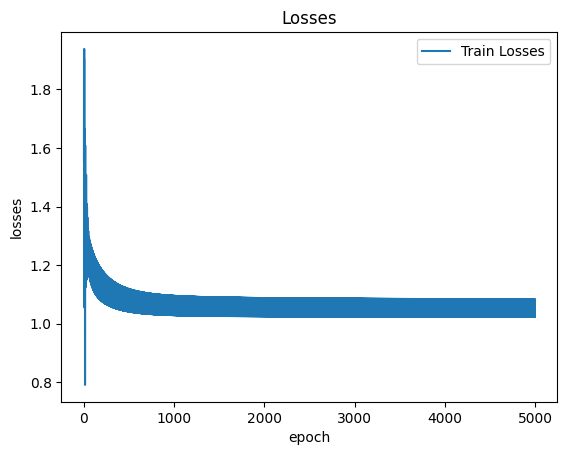

In [19]:
# Train the model with properly formatted data
model = Ridge(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001, l2=0.1)
model.fit(X_train_transformed, y_train_one_hot)
yhat = model.predict(X_test_transformed)
model.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("Report from custom model: \n", model.classification_report(y_test, yhat))

Loss at iteration 0 1.352261469877348
Loss at iteration 500 1.1139842918566456
Loss at iteration 500 1.1139842918566456
Loss at iteration 1000 1.090398753688354
Loss at iteration 1000 1.090398753688354
Loss at iteration 1500 1.0847154450085765
Loss at iteration 1500 1.0847154450085765
Loss at iteration 2000 1.0822320828413774
Loss at iteration 2000 1.0822320828413774
Loss at iteration 2500 1.0806782215639013
Loss at iteration 2500 1.0806782215639013
Loss at iteration 3000 1.0795600125186329
Loss at iteration 3000 1.0795600125186329
Loss at iteration 3500 1.0787164746354385
Loss at iteration 3500 1.0787164746354385
Loss at iteration 4000 1.0780673248923185
Loss at iteration 4000 1.0780673248923185
Loss at iteration 4500 1.0775600357361041
Loss at iteration 4500 1.0775600357361041
time taken: 5.431900262832642
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.93      0.62      0.74       411
           1       0.54 

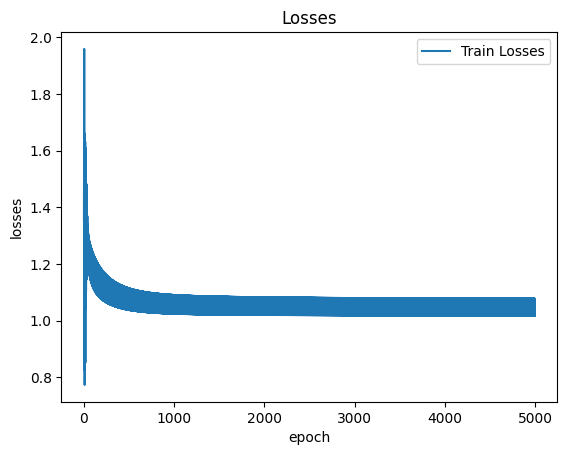

In [20]:
model2 = SimpleLogistic(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001)
model2.fit(X_train_transformed, y_train_one_hot)
yhat2 = model2.predict(X_test_transformed)
model2.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat2))
print("Report from custom model: \n", model2.classification_report(y_test, yhat2))

## Task 3: Deployment

### Set up MLFlow

In [21]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
# mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
os.environ["LOGNAME"] = "st126235"
mlflow.set_experiment("st126235-a3")

<Experiment: artifact_location='mlflow-artifacts:/607305997044080535', creation_time=1759391076743, experiment_id='607305997044080535', last_update_time=1759391076743, lifecycle_stage='active', name='st126235-a3', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [22]:
# Helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

===== Training SimpleLogistic with batch and learning rate 0.01 =====
Loss at iteration 0 2.1709566887083156
Loss at iteration 0 2.1709566887083156


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_26094/2897764598.py:66: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_26094/2897764598.py:66: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
Loss at iteration 4500 nan
time taken: 4.560324192047119
time taken: 4.560324192047119


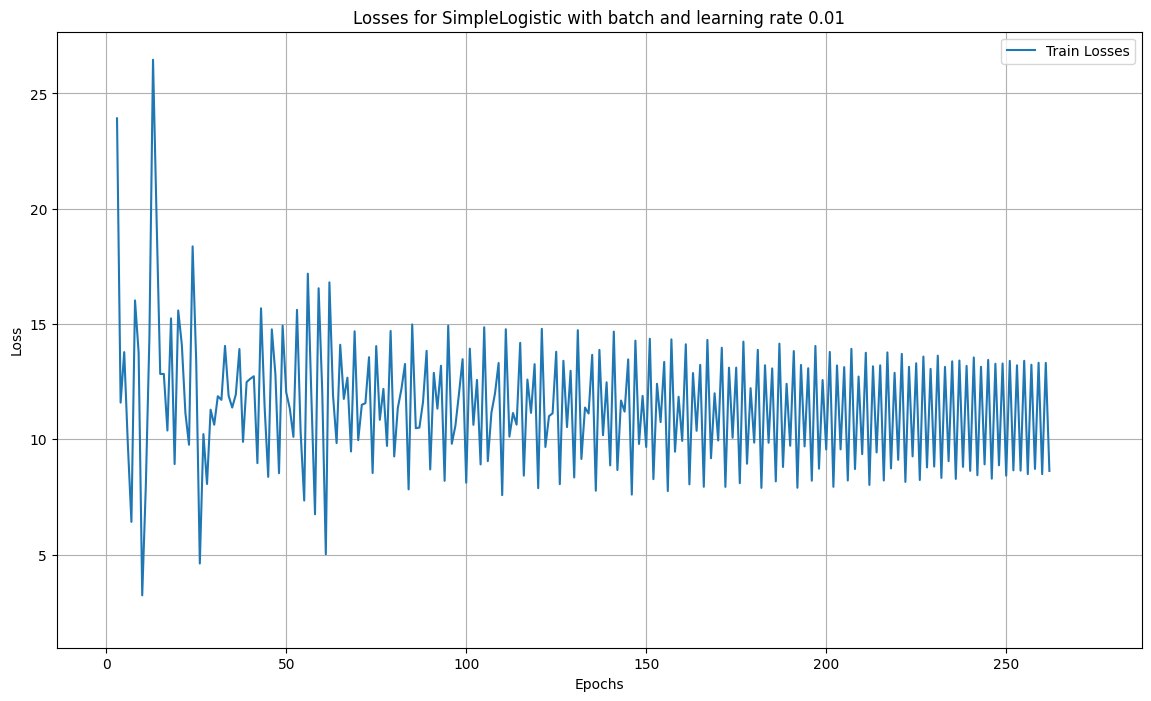

=========Classification report=======
             precision recall f1-score support
0                 0.68   0.96      0.8   411.0
1                 0.72   0.13     0.22   456.0
2                 0.46   0.91     0.61   352.0
3                 0.95   0.62     0.75   387.0
accuracy                          0.63    1606
macro avg          0.7   0.66      0.6  1606.0
weighted avg      0.71   0.63     0.58  1606.0
===== Training SimpleLogistic with batch and learning rate 0.001 =====
===== Training SimpleLogistic with batch and learning rate 0.001 =====
Loss at iteration 0 1.2927354184938484
Loss at iteration 0 1.2927354184938484
Loss at iteration 500 1.0379670630639068
Loss at iteration 500 1.0379670630639068
Loss at iteration 1000 1.0246348298526644
Loss at iteration 1000 1.0246348298526644
Loss at iteration 1500 1.021584568491756
Loss at iteration 1500 1.021584568491756
Loss at iteration 2000 1.02034889236165
Loss at iteration 2000 1.02034889236165
Loss at iteration 2500 1.0195884524697

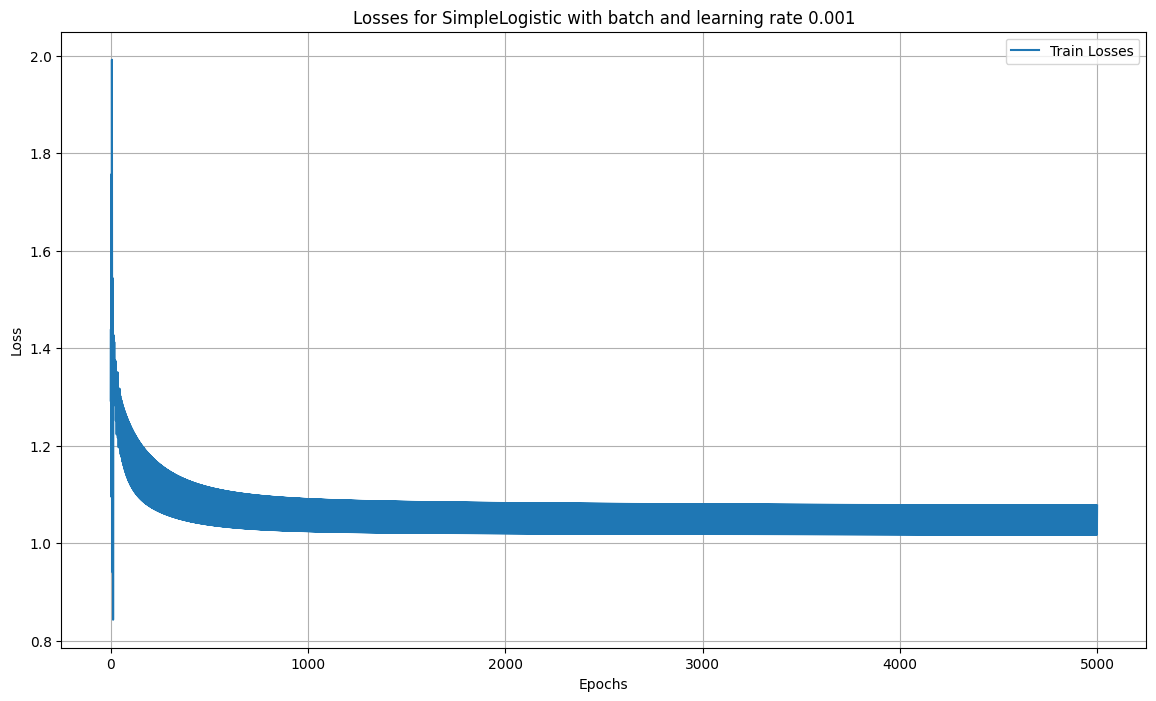

=========Classification report=======
             precision recall f1-score support
0                 0.71   0.95     0.81   411.0
1                  0.7   0.16     0.26   456.0
2                 0.46   0.89     0.61   352.0
3                 0.94   0.64     0.76   387.0
accuracy                          0.64    1606
macro avg          0.7   0.66     0.61  1606.0
weighted avg      0.71   0.64      0.6  1606.0
===== Training SimpleLogistic with batch and learning rate 0.0001 =====
===== Training SimpleLogistic with batch and learning rate 0.0001 =====
Loss at iteration 0 1.431030144572852
Loss at iteration 0 1.431030144572852
Loss at iteration 500 0.6086237673503244
Loss at iteration 500 0.6086237673503244
Loss at iteration 1000 0.5913015285593628
Loss at iteration 1000 0.5913015285593628
Loss at iteration 1500 0.5853950271850272
Loss at iteration 1500 0.5853950271850272
Loss at iteration 2000 0.5827225888497972
Loss at iteration 2000 0.5827225888497972
Loss at iteration 2500 0.5813060

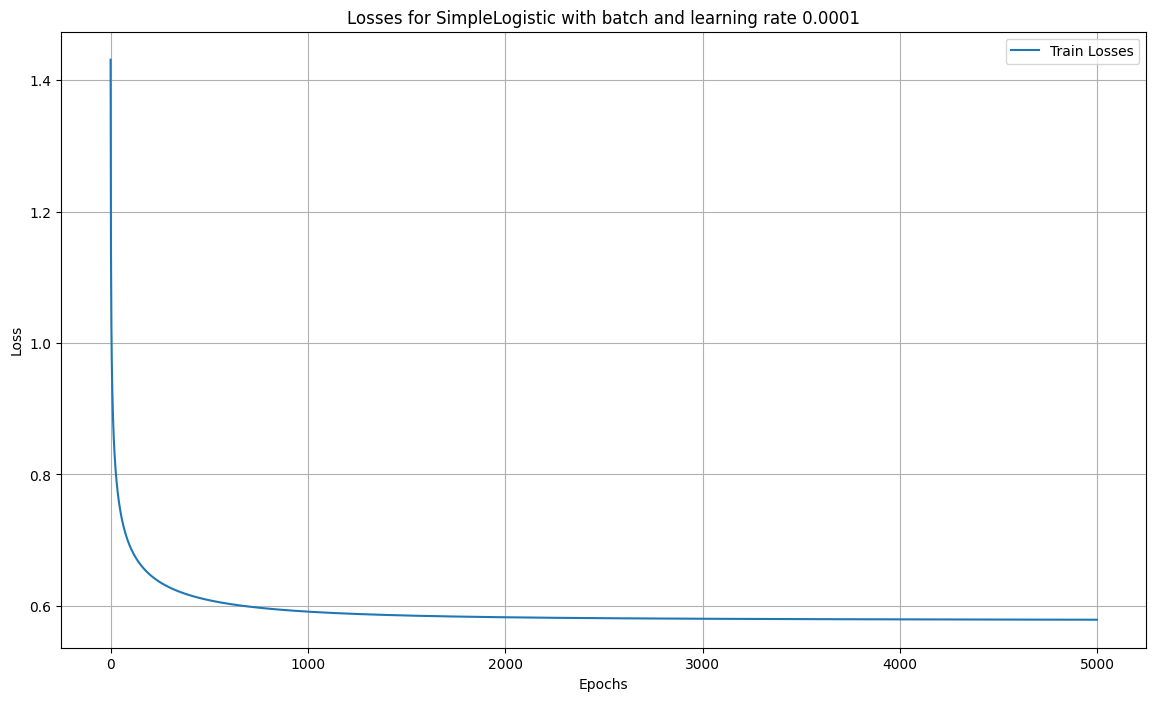

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.85     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.01 =====
===== Training SimpleLogistic with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.6189230380824537
Loss at iteration 500 0.9803271310822003
Loss at iteration 0 1.6189230380824537
Loss at iteration 500 0.9803271310822003
Loss at iteration 1000 0.986645708534222
Loss at iteration 1000 0.986645708534222
Loss at iteration 1500 1.26405873167764
Loss at iteration 2000 1.4870343901921916
Loss at iteration 1500 1.26405873167764
Loss at iteration 2000 1.4870343901921916
Loss at iteration 2500 2.9287108

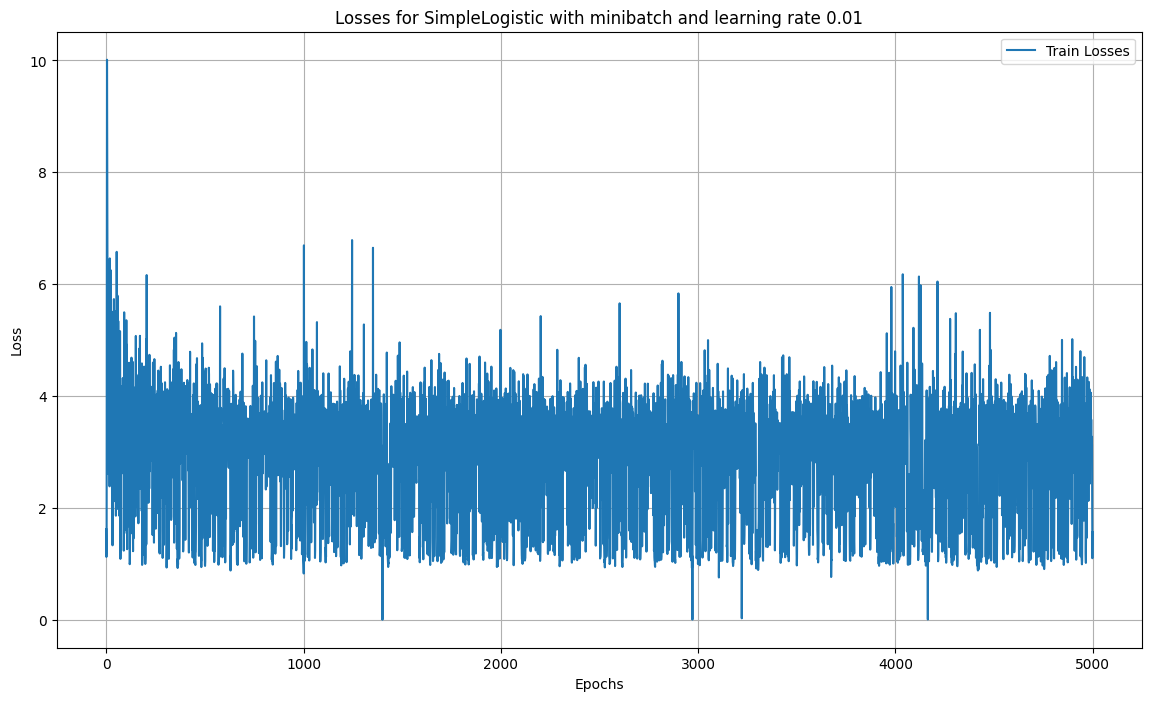

=========Classification report=======
             precision recall f1-score support
0                 0.77   0.92     0.84   411.0
1                 0.71   0.14     0.24   456.0
2                 0.41   0.93     0.57   352.0
3                 0.95   0.54     0.69   387.0
accuracy                          0.61    1606
macro avg         0.71   0.63     0.58  1606.0
weighted avg      0.72   0.61     0.57  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.001 =====
===== Training SimpleLogistic with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.8724003391238766
Loss at iteration 500 0.5692010132642042
Loss at iteration 0 1.8724003391238766
Loss at iteration 500 0.5692010132642042
Loss at iteration 1000 0.5672638067334432
Loss at iteration 1500 0.6018550962125128
Loss at iteration 1000 0.5672638067334432
Loss at iteration 1500 0.6018550962125128
Loss at iteration 2000 0.548444702944579
Loss at iteration 2500 0.5688701838883815
Loss at iteration 2000 0.

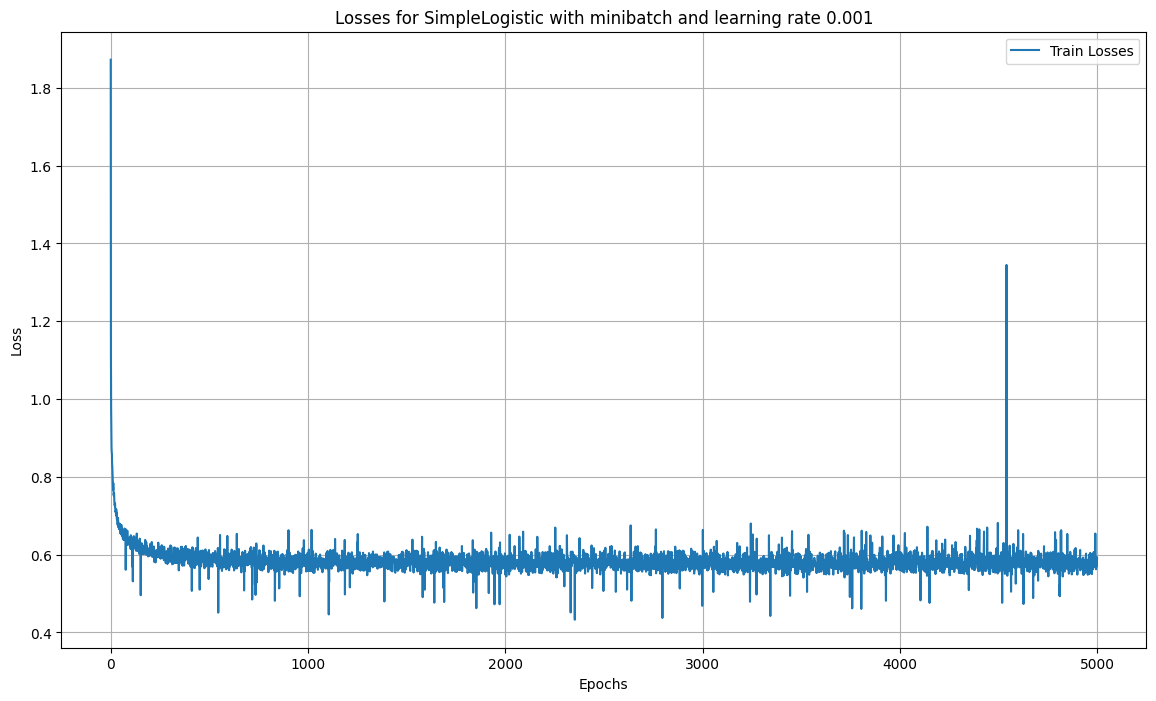

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.84     0.85   411.0
1                 0.71   0.68     0.69   456.0
2                 0.63   0.71     0.67   352.0
3                 0.88   0.84     0.86   387.0
accuracy                          0.77    1606
macro avg         0.77   0.77     0.77  1606.0
weighted avg      0.77   0.77     0.77  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.0001 =====
===== Training SimpleLogistic with minibatch and learning rate 0.0001 =====
Loss at iteration 0 1.793163099277043
Loss at iteration 500 0.6859676816937867
Loss at iteration 0 1.793163099277043
Loss at iteration 500 0.6859676816937867
Loss at iteration 1000 0.6272838182887855
Loss at iteration 1000 0.6272838182887855
Loss at iteration 1500 0.6229673427970579
Loss at iteration 2000 0.6159866571738707
Loss at iteration 1500 0.6229673427970579
Loss at iteration 2000 0.6159866571738707
Loss at iteration 2500 0

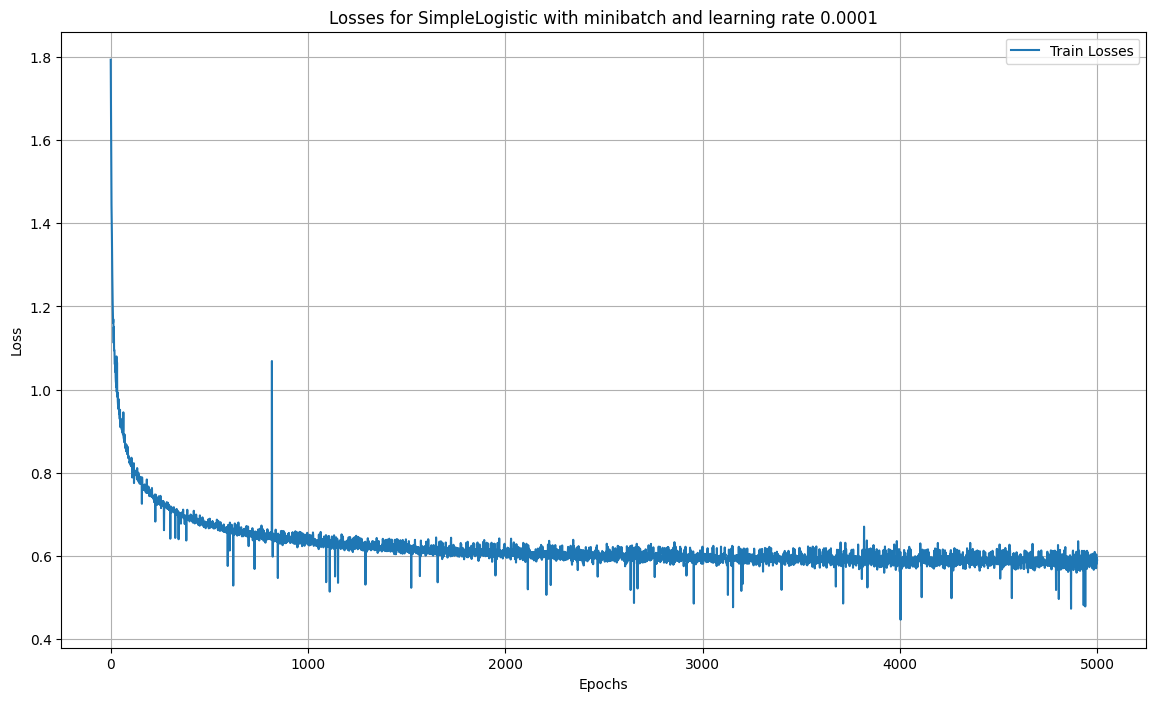

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.82     0.84   411.0
1                  0.7   0.68     0.69   456.0
2                 0.62   0.69     0.65   352.0
3                 0.87   0.83     0.85   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training SimpleLogistic with sto and learning rate 0.01 =====
===== Training SimpleLogistic with sto and learning rate 0.01 =====
Loss at iteration 0 1.8460988555863727
Loss at iteration 500 0.740720836285048
Loss at iteration 1000 1.3714923665424585
Loss at iteration 1500 0.6225049358856221
Loss at iteration 2000 1.4511265158492965
Loss at iteration 2500 1.303889560798305
Loss at iteration 3000 0.7028273115538272
Loss at iteration 3500 0.644030529604908
Loss at iteration 4000 0.7944045235370124
Loss at iteration 4500 0.7962450645133866
time taken: 0.14972424507141113
Loss 

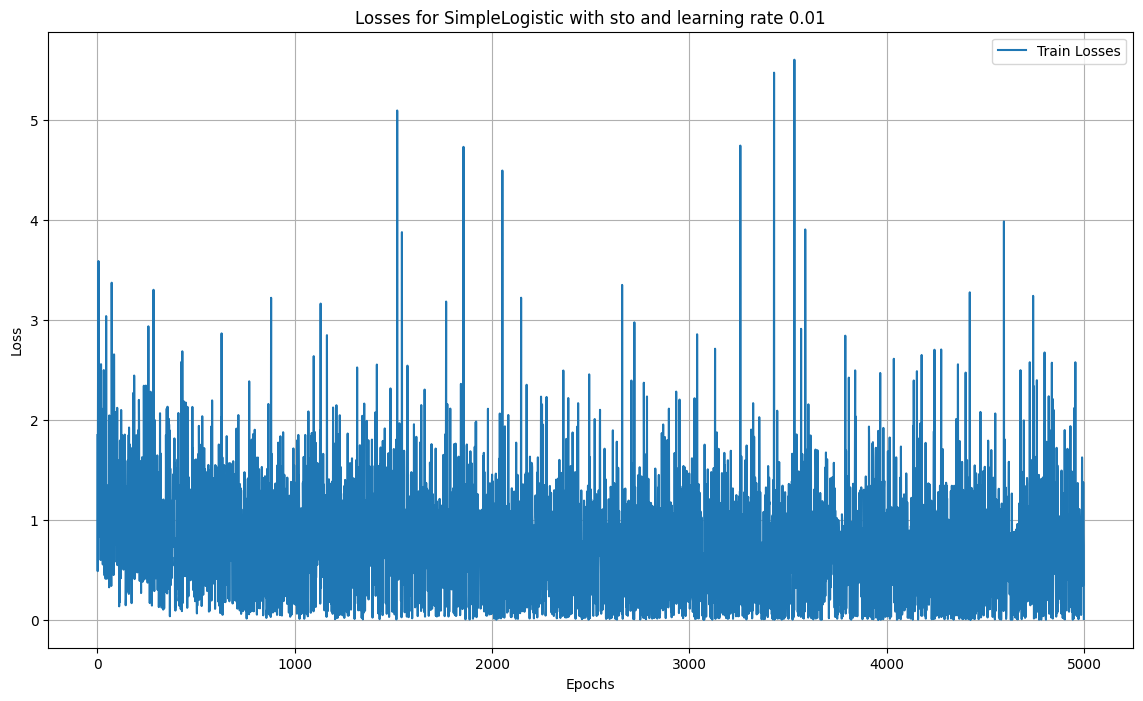

=========Classification report=======
             precision recall f1-score support
0                 0.79   0.89     0.84   411.0
1                 0.68   0.54      0.6   456.0
2                 0.55   0.59     0.57   352.0
3                 0.78   0.81      0.8   387.0
accuracy                          0.71    1606
macro avg          0.7   0.71      0.7  1606.0
weighted avg       0.7   0.71      0.7  1606.0
===== Training SimpleLogistic with sto and learning rate 0.001 =====
===== Training SimpleLogistic with sto and learning rate 0.001 =====
Loss at iteration 0 1.8947227128782254
Loss at iteration 500 1.344211332247409
Loss at iteration 1000 1.6179480655856004
Loss at iteration 1500 1.7264040531428766
Loss at iteration 2000 1.4429215923058538
Loss at iteration 2500 1.5285076536761755
Loss at iteration 3000 1.3343975592022819
Loss at iteration 3500 2.000718785505499
Loss at iteration 4000 1.373350186447402
Loss at iteration 4500 1.175687658579165
time taken: 0.15096426010131836
Loss

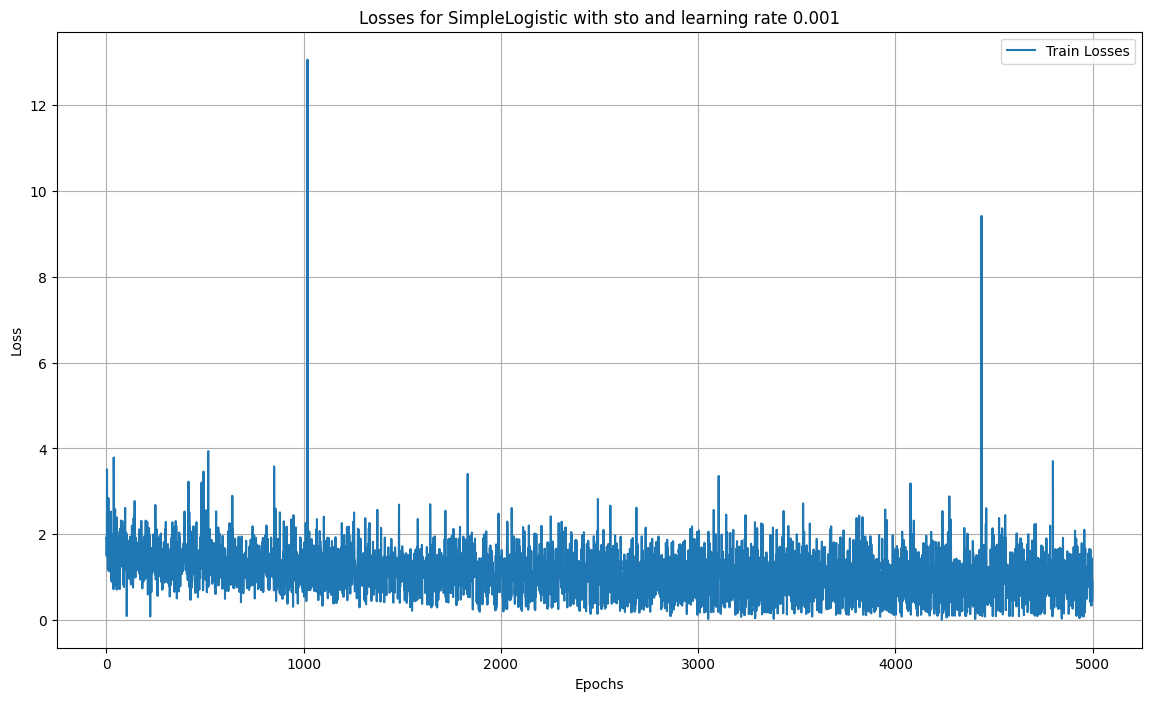

=========Classification report=======
             precision recall f1-score support
0                 0.61    0.8      0.7   411.0
1                 0.51   0.37     0.43   456.0
2                 0.44   0.37      0.4   352.0
3                 0.68   0.78     0.73   387.0
accuracy                          0.58    1606
macro avg         0.56   0.58     0.56  1606.0
weighted avg      0.56   0.58     0.56  1606.0
===== Training SimpleLogistic with sto and learning rate 0.0001 =====
===== Training SimpleLogistic with sto and learning rate 0.0001 =====
Loss at iteration 0 1.4848541809732598
Loss at iteration 500 1.0326113414597298
Loss at iteration 1000 1.3192415544046001
Loss at iteration 1500 2.8292000858053736
Loss at iteration 2000 1.0751079190312829
Loss at iteration 2500 2.530852171091075
Loss at iteration 3000 0.8398533771941584
Loss at iteration 3500 1.848308010465583
Loss at iteration 4000 1.735929243058173
Loss at iteration 4500 1.0399215854755446
time taken: 0.15426397323608398
L

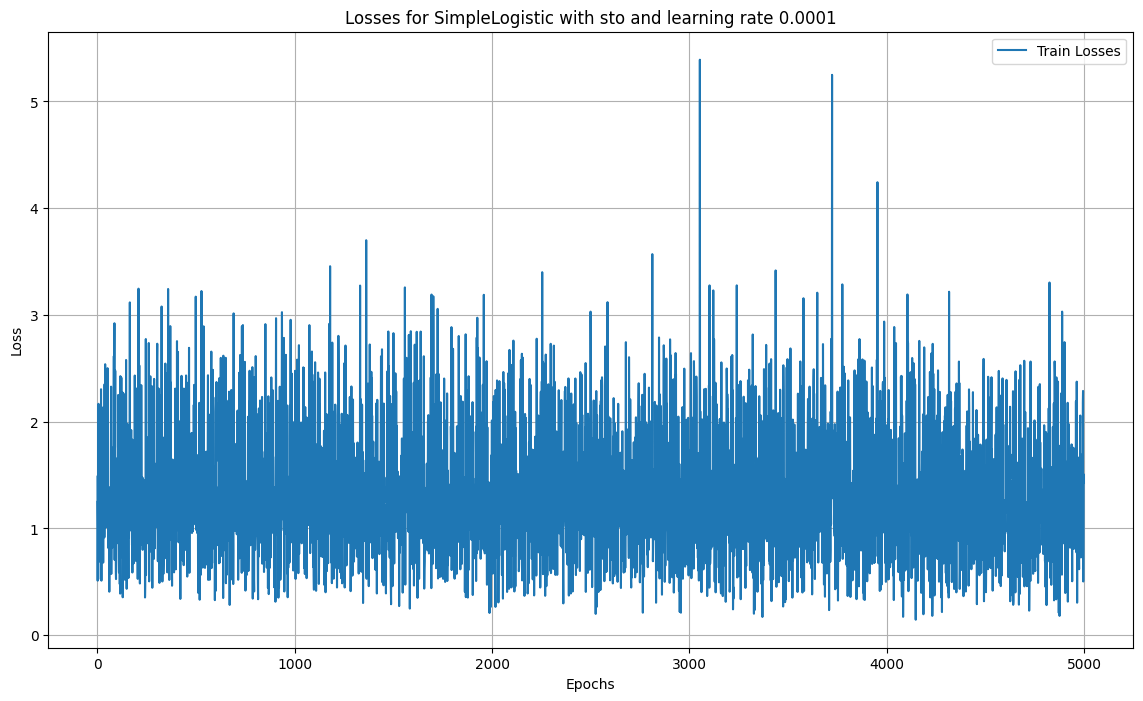

=========Classification report=======
             precision recall f1-score support
0                 0.48   0.76     0.59   411.0
1                 0.31   0.13     0.18   456.0
2                  0.3    0.3      0.3   352.0
3                  0.5   0.53     0.52   387.0
accuracy                          0.43    1606
macro avg          0.4   0.43      0.4  1606.0
weighted avg       0.4   0.43     0.39  1606.0
===== Training Ridge with batch and learning rate 0.01 =====
===== Training Ridge with batch and learning rate 0.01 =====
Loss at iteration 0 1.969018188777432
Loss at iteration 0 1.969018188777432


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_26094/2897764598.py:66: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_26094/2897764598.py:66: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
Loss at iteration 4500 nan
time taken: 4.691931962966919
time taken: 4.691931962966919


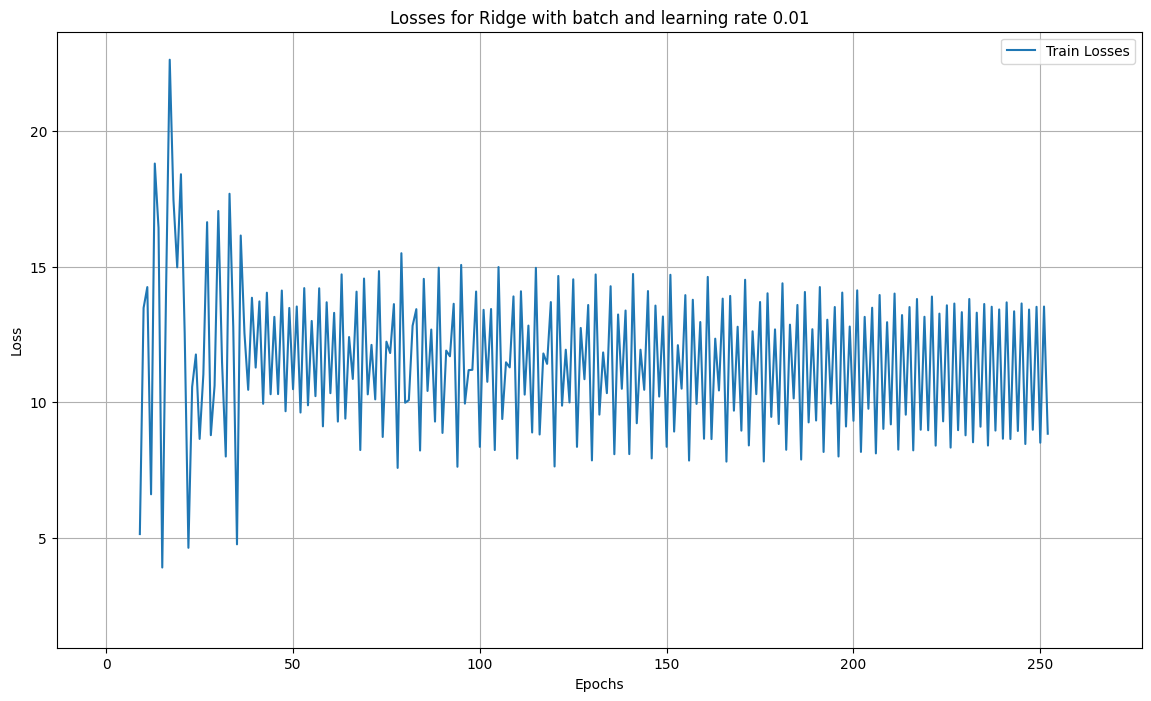

=========Classification report=======
             precision recall f1-score support
0                 0.68   0.96      0.8   411.0
1                 0.72   0.11     0.19   456.0
2                 0.46   0.93     0.61   352.0
3                 0.95   0.59     0.73   387.0
accuracy                          0.62    1606
macro avg          0.7   0.65     0.58  1606.0
weighted avg      0.71   0.62     0.57  1606.0
===== Training Ridge with batch and learning rate 0.001 =====
===== Training Ridge with batch and learning rate 0.001 =====
Loss at iteration 0 1.6643679072884445
Loss at iteration 0 1.6643679072884445
Loss at iteration 500 1.1177229965261248
Loss at iteration 500 1.1177229965261248
Loss at iteration 1000 1.0947473756391495
Loss at iteration 1000 1.0947473756391495
Loss at iteration 1500 1.0893692712076781
Loss at iteration 1500 1.0893692712076781
Loss at iteration 2000 1.0871048455331476
Loss at iteration 2000 1.0871048455331476
Loss at iteration 2500 1.085738233787323
Loss at i

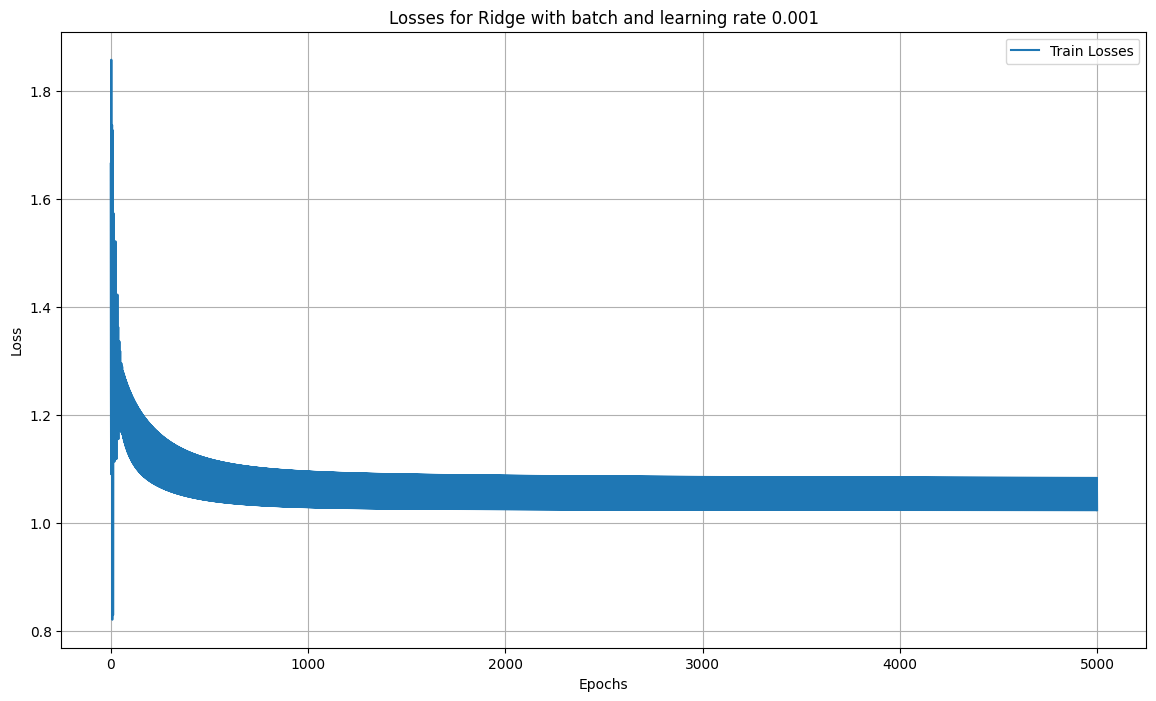

=========Classification report=======
             precision recall f1-score support
0                 0.93   0.62     0.74   411.0
1                 0.54   0.87     0.66   456.0
2                 0.53   0.11     0.19   352.0
3                 0.69   0.93     0.79   387.0
accuracy                          0.65    1606
macro avg         0.67   0.63      0.6  1606.0
weighted avg      0.67   0.65     0.61  1606.0
===== Training Ridge with batch and learning rate 0.0001 =====
===== Training Ridge with batch and learning rate 0.0001 =====
Loss at iteration 0 1.4242597222052322
Loss at iteration 0 1.4242597222052322
Loss at iteration 500 0.6090926039686813
Loss at iteration 500 0.6090926039686813
Loss at iteration 1000 0.5923845558567882
Loss at iteration 1000 0.5923845558567882
Loss at iteration 1500 0.586785540160045
Loss at iteration 1500 0.586785540160045
Loss at iteration 2000 0.5842802112604879
Loss at iteration 2000 0.5842802112604879
Loss at iteration 2500 0.5829699239886291
Loss at 

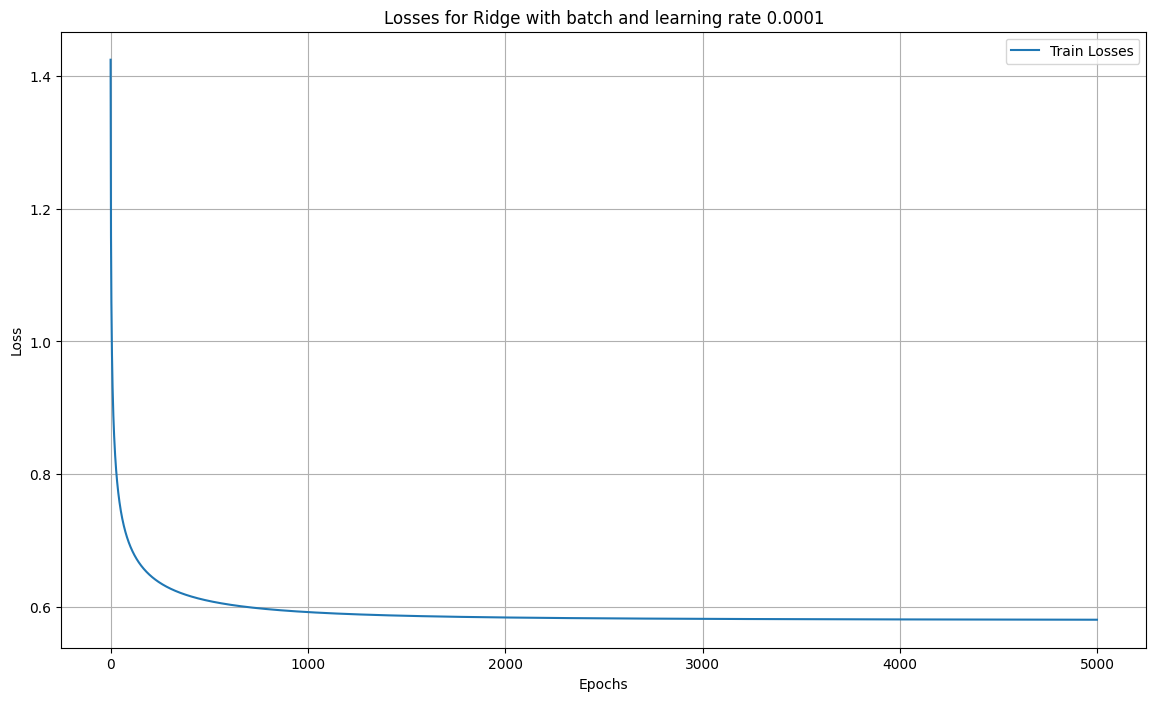

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.85     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with minibatch and learning rate 0.01 =====
===== Training Ridge with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.7321492293423857
Loss at iteration 500 4.5802136508878055
Loss at iteration 0 1.7321492293423857
Loss at iteration 500 4.5802136508878055
Loss at iteration 1000 1.3078455941505325
Loss at iteration 1500 3.103930909243566
Loss at iteration 1000 1.3078455941505325
Loss at iteration 1500 3.103930909243566
Loss at iteration 2000 2.0882416616126327
Loss at iteration 2500 1.2299989634745083
Loss at iteration 2000 2.0882416616126327
Loss

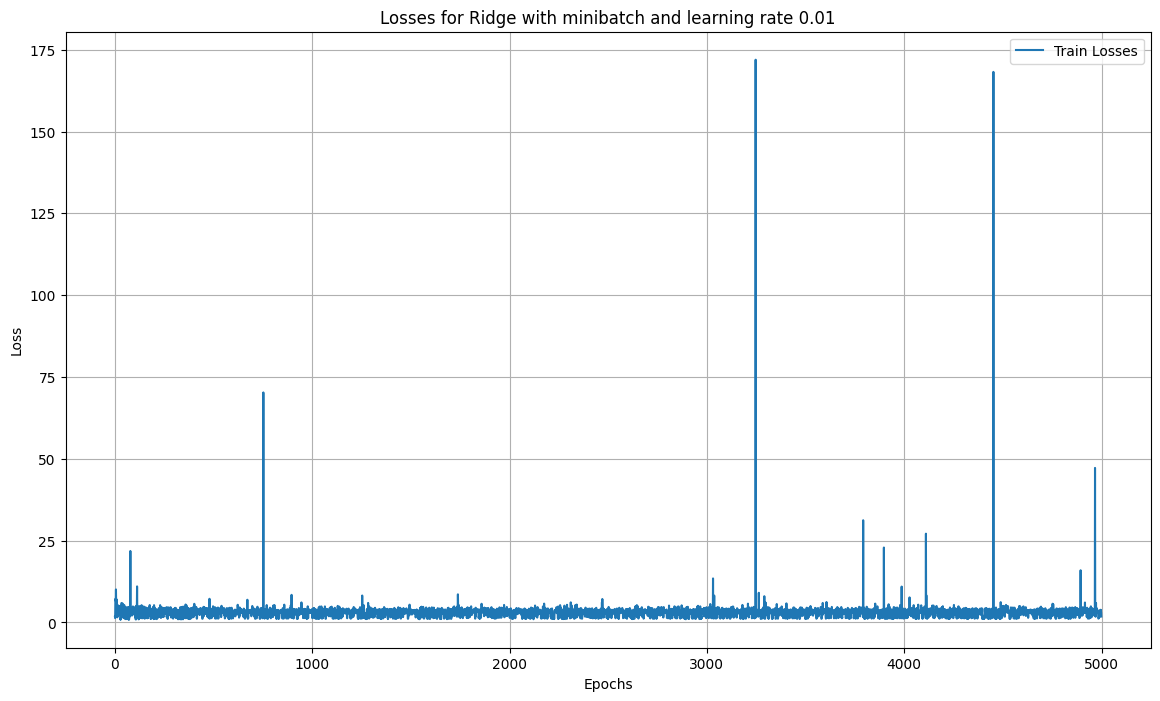

=========Classification report=======
             precision recall f1-score support
0                 0.95   0.51     0.67   411.0
1                 0.49    0.9     0.64   456.0
2                 0.52   0.09     0.15   352.0
3                 0.72   0.91      0.8   387.0
accuracy                          0.63    1606
macro avg         0.67    0.6     0.57  1606.0
weighted avg      0.67   0.63     0.58  1606.0
===== Training Ridge with minibatch and learning rate 0.001 =====
===== Training Ridge with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.4969875868023295
Loss at iteration 500 0.8526458420149652
Loss at iteration 0 1.4969875868023295
Loss at iteration 500 0.8526458420149652
Loss at iteration 1000 0.6437880928676376
Loss at iteration 1500 0.572021771739811
Loss at iteration 1000 0.6437880928676376
Loss at iteration 1500 0.572021771739811
Loss at iteration 2000 0.6058725738287561
Loss at iteration 2500 0.5891801648653556
Loss at iteration 2000 0.6058725738287561
Lo

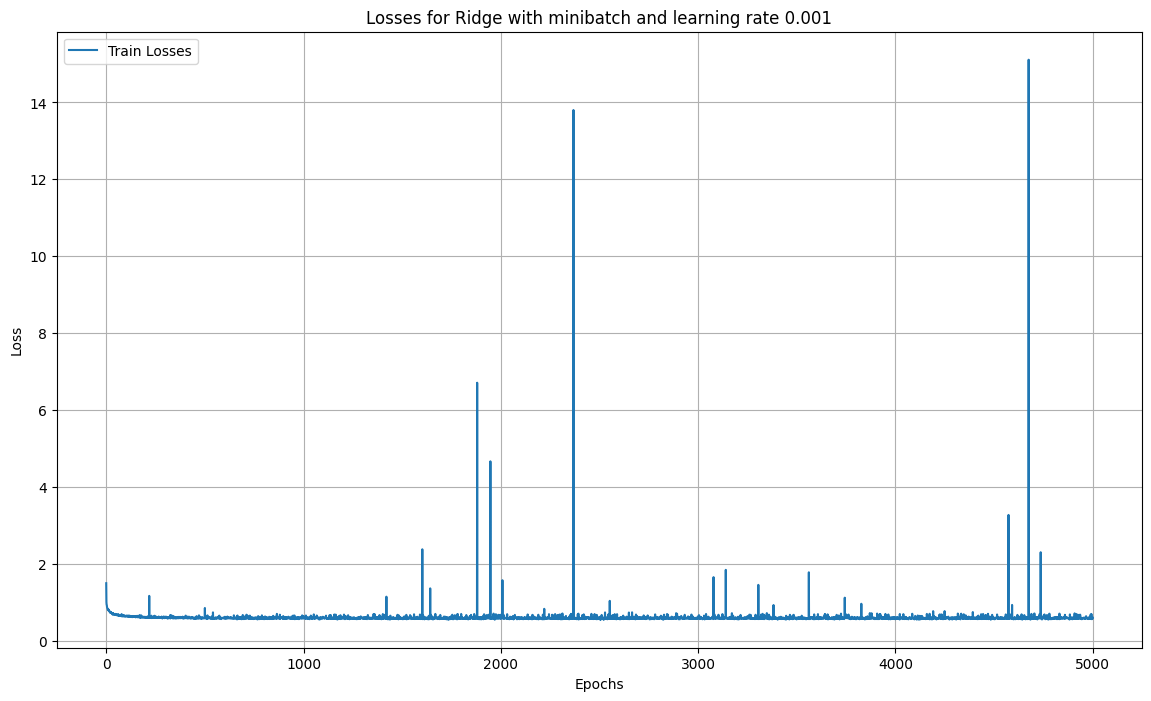

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                  0.7   0.68     0.69   456.0
2                 0.62   0.68     0.65   352.0
3                 0.85   0.84     0.85   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with minibatch and learning rate 0.0001 =====
===== Training Ridge with minibatch and learning rate 0.0001 =====
Loss at iteration 0 1.7055274094654205
Loss at iteration 0 1.7055274094654205
Loss at iteration 500 0.673741275363488
Loss at iteration 1000 0.6343303872088385
Loss at iteration 500 0.673741275363488
Loss at iteration 1000 0.6343303872088385
Loss at iteration 1500 0.6374984772752015
Loss at iteration 1500 0.6374984772752015
Loss at iteration 2000 0.615033204011112
Loss at iteration 2000 0.615033204011112
Loss at iteration 2500 0.6096875962146692
Lo

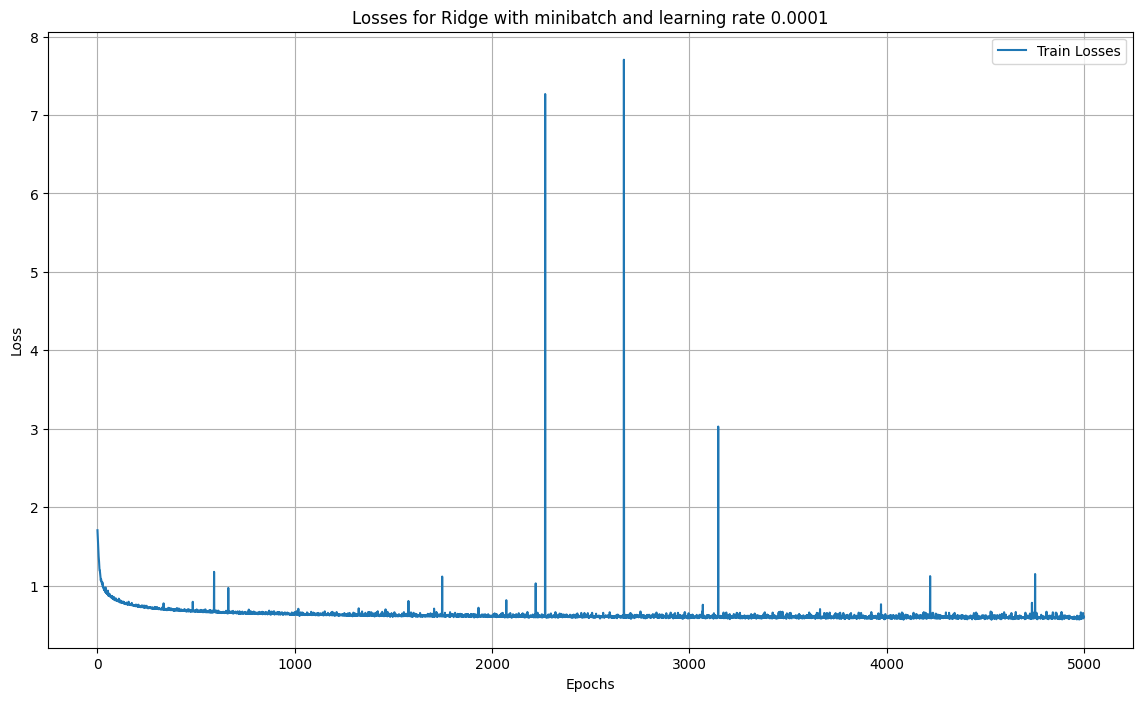

=========Classification report=======
             precision recall f1-score support
0                 0.84   0.82     0.83   411.0
1                 0.69   0.67     0.68   456.0
2                 0.61   0.67     0.64   352.0
3                 0.86   0.83     0.85   387.0
accuracy                          0.75    1606
macro avg         0.75   0.75     0.75  1606.0
weighted avg      0.75   0.75     0.75  1606.0
===== Training Ridge with sto and learning rate 0.01 =====
===== Training Ridge with sto and learning rate 0.01 =====
Loss at iteration 0 3.707559344501696
Loss at iteration 500 1.3344108923486062
Loss at iteration 1000 0.763224125924276
Loss at iteration 1500 1.1605383386492543
Loss at iteration 2000 0.7316999552469273
Loss at iteration 2500 1.2147184417329737
Loss at iteration 3000 0.6015756992302267
Loss at iteration 3500 1.7618720867095983
Loss at iteration 4000 1.1174218776237321
Loss at iteration 4500 0.5612222461520903
time taken: 0.13939499855041504
Loss at iteration 0 3.

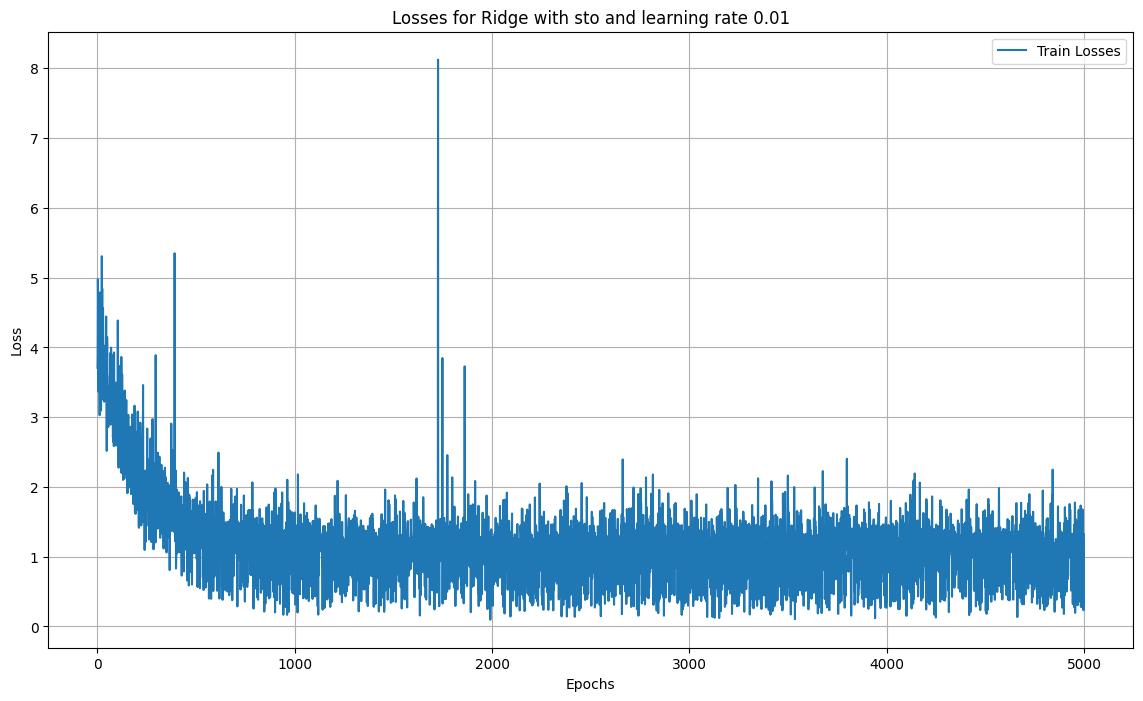

=========Classification report=======
             precision recall f1-score support
0                 0.73   0.76     0.74   411.0
1                 0.45   0.73     0.55   456.0
2                 0.57   0.08     0.14   352.0
3                 0.75   0.75     0.75   387.0
accuracy                           0.6    1606
macro avg         0.62   0.58     0.55  1606.0
weighted avg      0.62    0.6     0.56  1606.0
===== Training Ridge with sto and learning rate 0.001 =====
===== Training Ridge with sto and learning rate 0.001 =====
Loss at iteration 0 5.153324865004676
Loss at iteration 500 3.840066365773759
Loss at iteration 1000 2.9993658579748965
Loss at iteration 1500 2.340242775976026
Loss at iteration 2000 2.6309535300081826
Loss at iteration 2500 2.3369661960892056
Loss at iteration 3000 1.8924926448604822
Loss at iteration 3500 1.1038136243768846
Loss at iteration 4000 1.996158842745634
Loss at iteration 4500 1.3443406568694543
time taken: 0.1413710117340088
Loss at iteration 0 5.1

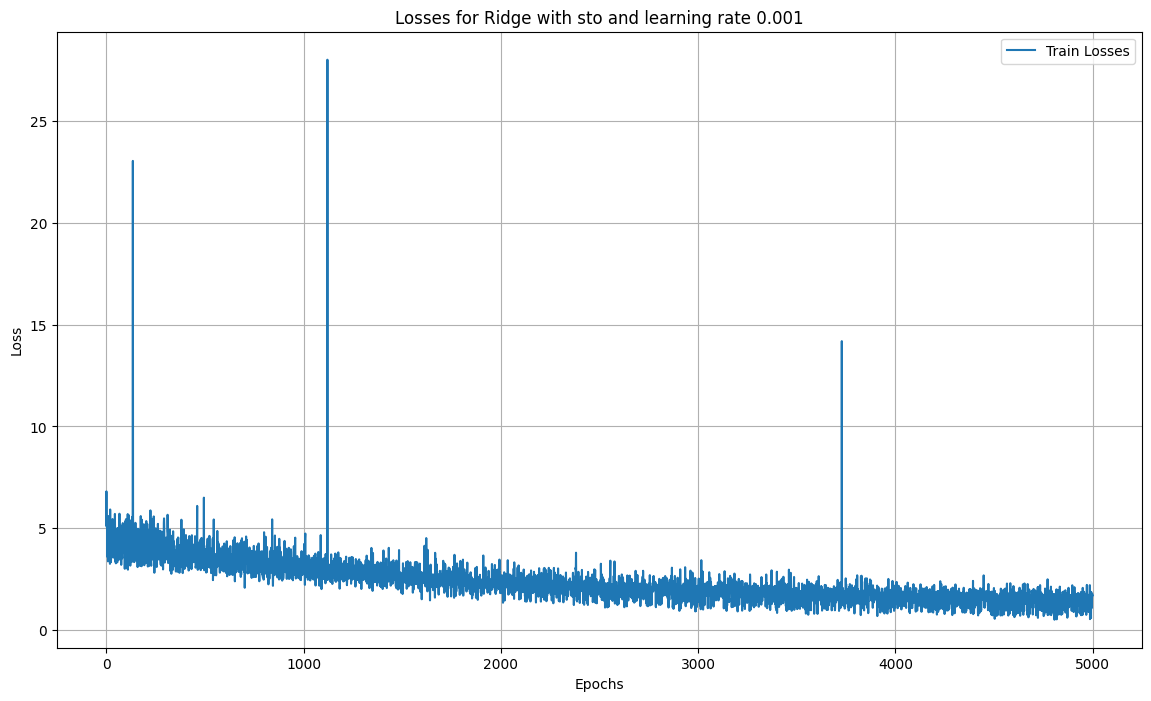

=========Classification report=======
             precision recall f1-score support
0                 0.65   0.89     0.75   411.0
1                 0.46   0.26     0.33   456.0
2                 0.42   0.41     0.41   352.0
3                 0.69   0.78     0.73   387.0
accuracy                          0.58    1606
macro avg         0.55   0.58     0.56  1606.0
weighted avg      0.55   0.58     0.55  1606.0
===== Training Ridge with sto and learning rate 0.0001 =====
===== Training Ridge with sto and learning rate 0.0001 =====
Loss at iteration 0 2.969683547806538
Loss at iteration 500 3.9641879885892743
Loss at iteration 1000 3.2646885062140347
Loss at iteration 1500 3.4105095210142338
Loss at iteration 2000 2.7771081671824227
Loss at iteration 2500 2.880174748902082
Loss at iteration 3000 2.8520215633126584
Loss at iteration 3500 3.409250209002257
Loss at iteration 4000 2.7351270445676295
Loss at iteration 4500 2.656249348458264
time taken: 0.14270281791687012
Loss at iteration 0 

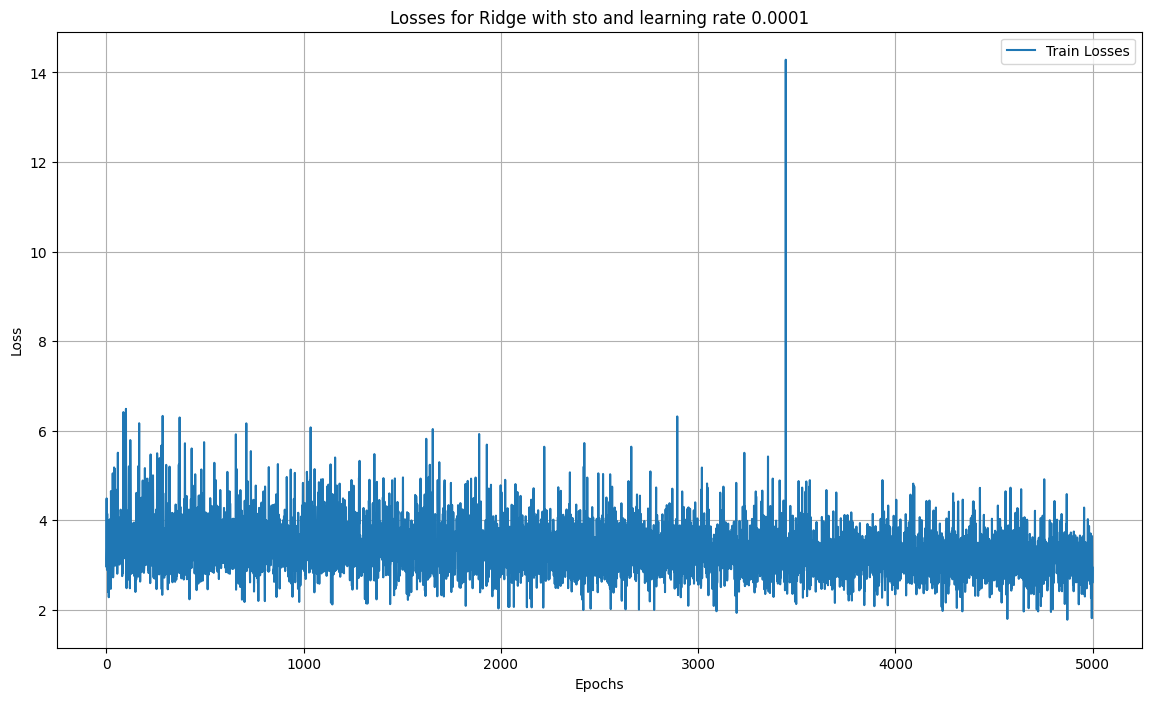

=========Classification report=======
             precision recall f1-score support
0                 0.18   0.19     0.18   411.0
1                 0.33   0.61     0.43   456.0
2                 0.11   0.02     0.03   352.0
3                 0.76    0.5      0.6   387.0
accuracy                          0.35    1606
macro avg         0.34   0.33     0.31  1606.0
weighted avg      0.35   0.35     0.32  1606.0


In [23]:
regs = ["SimpleLogistic", "Ridge"]
methods = ["batch", "minibatch", "sto"]
alphas = [0.01, 0.001, 0.0001]

for reg in regs:
    for method in methods:
        for alpha in alphas:

                if reg == "Ridge":
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha,
                        "l2": 0.1
                    }
                else:
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha
                    }

                with mlflow.start_run(run_name=f"{reg}-method-{method}-learning_rate-{alpha}", nested=True):

                    print("=" * 5, f"Training {reg} with {method} and learning rate {alpha}", "=" * 5)
                    
                    for key, value in params.items():
                        mlflow.log_param(key, value)

                    logis_type = str_to_class(reg)
                    model = logis_type(**params)
                    model.fit(X_train_transformed, y_train_one_hot)
                    yhat = model.predict(X_test_transformed)
                    fig, ax = plt.subplots(figsize=(14,8))
                    model.plot()
                    plt.title(f"Losses for {reg} with {method} and learning rate {alpha}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.grid()
                    if not os.path.exists("./figures"):
                        os.makedirs("./figures")
                    # Save figure image to figure folder
                    fig_path = f"./figures/{reg}-{method}-{alpha}.png"
                    plt.savefig(fig_path)
                    mlflow.log_artifact(fig_path, artifact_path="figures")
                    plt.show()
                    print("=========Classification report=======")
                    print(model.classification_report(y_test, yhat))
                    # Log all metrics to MLflow calculate function by function
                    acc = model.accuracy(y_test, yhat)
                    macro_prec = model.macro_precision(y_test, yhat)
                    macro_rec = model.macro_recall(y_test, yhat)
                    macro_f1 = model.macro_f1_score(y_test, yhat)
                    weighted_prec = model.weighted_precision(y_test, yhat)
                    weighted_rec = model.weighted_recall(y_test, yhat)
                    weighted_f1 = model.weighted_f1_score(y_test, yhat)
                    mlflow.log_metric("accuracy", acc)
                    mlflow.log_metric("macro_precision", macro_prec)
                    mlflow.log_metric("macro_recall", macro_rec)
                    mlflow.log_metric("macro_f1", macro_f1)
                    mlflow.log_metric("weighted_precision", weighted_prec)
                    mlflow.log_metric("weighted_recall", weighted_rec)
                    mlflow.log_metric("weighted_f1", weighted_f1)
                    for cls in np.unique(y_test):
                        prec = model.precision(y_test, yhat, cls)
                        rec = model.recall(y_test, yhat, cls)
                        f1 = model.f1_score(y_test, yhat, cls)
                        mlflow.log_metric(f"precision_class_{cls}", prec)
                        mlflow.log_metric(f"recall_class_{cls}", rec)
                        mlflow.log_metric(f"f1_score_class_{cls}", f1)
                    # signature = mlflow.models.infer_signature(X_train_transformed, yhat)
                    # mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)


In [24]:
# Find the best model 
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

client = MlflowClient()
experiment = client.get_experiment_by_name("st126235-a3")

# Pull runs in experiment then sort to find best macro_f1
runs = client.search_runs(
    [experiment.experiment_id],
    order_by=["metrics.macro_f1 DESC"],
    max_results = 1
)

best_run = runs[0]
run_id = best_run.info.run_id
print("Best run ID:", run_id)
print("Best macro_f1:", best_run.data.metrics["macro_f1"])

Best run ID: 4db68789e2c446b9a1e13a5aa51bd9fe
Best macro_f1: 0.7667186914508197


In [26]:
# Log model to MLFlow for the best run
params = best_run.data.params
print("Best run parameters:", params)
with mlflow.start_run(run_name=f"Best_model_{run_id}") as run:
    # Check if params includes l2 for Ridge or not for SimpleLogistic
    if 'l2' in params:
        model = Ridge(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha']),
            l2=float(params['l2'])
        )
    else:
        model = SimpleLogistic(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha'])
        )
    mlflow.log_params(params)
    model.fit(X_train_transformed, y_train_one_hot)
    yhat = model.predict(X_test_transformed)
    print("=========Classification report=======")
    print(model.classification_report(y_test, yhat))
    # Log all metrics to MLflow calculate function by function
    acc = model.accuracy(y_test, yhat)
    macro_prec = model.macro_precision(y_test, yhat)
    macro_rec = model.macro_recall(y_test, yhat)
    macro_f1 = model.macro_f1_score(y_test, yhat)
    weighted_prec = model.weighted_precision(y_test, yhat)
    weighted_rec = model.weighted_recall(y_test, yhat)
    weighted_f1 = model.weighted_f1_score(y_test, yhat)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("macro_precision", macro_prec)
    mlflow.log_metric("macro_recall", macro_rec)
    mlflow.log_metric("macro_f1", macro_f1)
    mlflow.log_metric("weighted_precision", weighted_prec)
    mlflow.log_metric("weighted_recall", weighted_rec)
    mlflow.log_metric("weighted_f1", weighted_f1)
    for cls in np.unique(y_test):
        prec = model.precision(y_test, yhat, cls)
        rec = model.recall(y_test, yhat, cls)
        f1 = model.f1_score(y_test, yhat, cls)
        mlflow.log_metric(f"precision_class_{cls}", prec)
        mlflow.log_metric(f"recall_class_{cls}", rec)
        mlflow.log_metric(f"f1_class_{cls}", f1)
    signature = mlflow.models.infer_signature(X_train_transformed, yhat)
    mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)

    current_run_id = run.info.run_id
    print("Current run ID:", current_run_id)

Best run parameters: {'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}
Loss at iteration 0 1.6456007308160339
Loss at iteration 500 0.53572009186927
Loss at iteration 0 1.6456007308160339
Loss at iteration 500 0.53572009186927
Loss at iteration 1000 0.6095480555498514
Loss at iteration 1500 0.584597376638806
Loss at iteration 1000 0.6095480555498514
Loss at iteration 1500 0.584597376638806
Loss at iteration 2000 0.5632944405763168
Loss at iteration 2500 0.5813377862205653
Loss at iteration 2000 0.5632944405763168
Loss at iteration 2500 0.5813377862205653
Loss at iteration 3000 0.5797940064086405
Loss at iteration 3500 0.6045171546423976
Loss at iteration 3000 0.5797940064086405
Loss at iteration 3500 0.6045171546423976
Loss at iteration 4000 0.5846478992718824
Loss at iteration 4500 0.5530449930622765
Loss at iteration 4000 0.5846478992718824
Loss at iteration 4500 0.5530449930622765
time taken: 1.403442144393921
=========Classification report=======
             precision

2025/10/03 22:58:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Current run ID: e9a6a4e1dd4d42f5bae28b17213d34c8


In [27]:
# Register model
model_uri = f"runs:/{current_run_id}/model"
model_name = "st126235-a3-model"
try:
    result = mlflow.register_model(model_uri, model_name)
    print(f"Model registered: {result.name}, version: {result.version}")
    model_version = result.version
    # Add time sleep
    time.sleep(2)  # Wait for a few seconds to ensure the model is registered
except RestException as e:
    print(f"Model registration failed: {e}")

Registered model 'st126235-a3-model' already exists. Creating a new version of this model...
2025/10/03 22:58:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126235-a3-model, version 6
2025/10/03 22:58:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126235-a3-model, version 6
Created version '6' of model 'st126235-a3-model'.
Created version '6' of model 'st126235-a3-model'.


Model registered: st126235-a3-model, version: 6


In [28]:
# Check registered model in mlflow
for rm in mlflow.search_registered_models():
    if rm.name == model_name:
        print(f"Model name: {rm.name}")
        for mv in rm.latest_versions:
            print(f"  Version: {mv.version}, Stage: {mv.current_stage}, Status: {mv.status}")



Model name: st126235-a3-model
  Version: 4, Stage: Archived, Status: READY
  Version: 6, Stage: None, Status: READY
  Version: 5, Stage: Staging, Status: READY


In [29]:
print(mlflow.__version__)

2.8.1


In [30]:
# Check if model version exists and is ready

try:
    model_version_details = client.get_model_version(name=model_name, version=model_version)
    print(f"Model version status: {model_version_details.status}")
    
    if model_version_details.status == "READY":
        # Add alias to the model version
        alias_name = "Staging"
        try:
            # Ensure the version is passed as a string to set_registered_model_alias
            client.set_registered_model_alias(name=model_name, alias=alias_name, version=str(model_version))
            print(f"Alias '{alias_name}' set for model version {model_version}")
        except Exception as e:
            print(f"Failed to set alias: {e}")
        # Transition the model to staging
        client.transition_model_version_stage(
            name=model_name, 
            version=int(model_version), 
            stage="Staging",
            archive_existing_versions=True
        )
        print(f"Model version {model_version} transitioned to Staging")
    else:
        print(f"Model version not ready. Current status: {model_version_details.status}")
        
except Exception as e:
    print(f"Error during transition: {e}")

Model version status: READY
Alias 'Staging' set for model version 6
Alias 'Staging' set for model version 6
Model version 6 transitioned to Staging
Model version 6 transitioned to Staging


In [31]:
# Load staging model
loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}/staging")

In [32]:
# Inference with the model
synthetic_data = {
    'year': [2014, 2015],
    'km_driven': [50000, 30000],
    'fuel': ['Diesel', 'Petrol'],
    'transmission': ['Manual', 'Automatic'],
    'owner': [1, 1],
    'engine': [1500, 1200],
    'max_power': [100, 80],
    'brand': ['Maruti', 'Hyundai'],
    'mileage': [18.0, 20.0]
}
X_synthetic = pd.DataFrame(synthetic_data)
X_synthetic_transformed = prep.transform(X_synthetic)
predictions = loaded_model.predict(X_synthetic_transformed)
print("Details of synthetic data samples:\n", X_synthetic)
print("The first synthetic data sample predicted class:", predictions[0])
print("The second synthetic data sample predicted class:", predictions[1])


Details of synthetic data samples:
    year  km_driven    fuel transmission  owner  engine  max_power    brand  \
0  2014      50000  Diesel       Manual      1    1500        100   Maruti   
1  2015      30000  Petrol    Automatic      1    1200         80  Hyundai   

   mileage  
0     18.0  
1     20.0  
The first synthetic data sample predicted class: 3
The second synthetic data sample predicted class: 1


In [33]:
# Conclude the best model parameters
print("Best model parameters:", params)

Best model parameters: {'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}


## Experiment Report